# Introdução às Redes Neurais Convolucionais em Grafos para Séries Temporais

As **Redes Neurais Convolucionais em Grafos** (Graph Convolutional Networks, ou GCNs) têm se mostrado uma ferramenta poderosa para capturar padrões complexos em dados estruturados em forma de grafos, como redes de transporte, redes sociais e interações moleculares. No entanto, muitos problemas no mundo real também envolvem uma dimensão temporal, onde as relações entre as entidades mudam com o tempo. Isso exige a criação de modelos capazes de capturar **dependências espaciais** e **temporais** simultaneamente.

A combinação dessas duas dimensões resulta em uma nova classe de problemas conhecidos como **Redes Neurais Espaciais-Temporais em Grafos** (Spatio-Temporal Graph Neural Networks, ou ST-GNNs). Esses modelos são aplicados em uma variedade de tarefas, como previsão de tráfego, análise de redes de sensores e modelagem de interações dinâmicas em redes sociais.

Nesta apresentação, exploraremos como a GCN pode ser expandida para lidar com séries temporais, capturando tanto a estrutura do grafo quanto as mudanças ao longo do tempo. Vamos focar em exemplos práticos, como a **previsão de tráfego**, onde o tráfego entre diferentes segmentos de estrada é modelado como um grafo cujas características variam ao longo do tempo.

## Definição

Dado um grafo dinâmico $G(t) = (V, E, X_V(t), X_E(t))$, onde:

- $V$ é o conjunto de nós (vértices),
- $E$ é o conjunto de arestas (conexões entre os nós),
- $X_V(t) \in \mathbb{R}^{|V| \times d_V}$ representa as características dos nós (vértices) no tempo $t$, sendo $d_V$ a dimensionalidade das características dos nós,
- $X_E(t) \in \mathbb{R}^{|E| \times d_E}$ representa as características das arestas no tempo $t$, sendo $d_E$ a dimensionalidade das características das arestas.

![example](st_gnn.png)

# Motivação: Previsão de Trafégo

Neste exemplo, mostramos como prever as condições de tráfego utilizando redes neurais baseadas em grafos **(GNNs)** combinadas com **LSTM**. O foco é prever os valores futuros da velocidade do tráfego com base em um histórico de dados de uma coleção de segmentos de estrada.

Uma solução tradicional para este tipo de problema é tratar a velocidade de tráfego de cada segmento de estrada como uma série temporal individual, prevendo os valores futuros com base nos dados passados do próprio segmento. Entretanto, essa abordagem não considera as influências que os segmentos vizinhos exercem entre si.

Para capturar as interações complexas entre os diferentes segmentos de estrada, podemos modelar a rede de tráfego como um grafo, onde a velocidade do tráfego é representada como um sinal associado a esse grafo. Nesta abordagem, implementamos uma arquitetura de rede neural capaz de processar séries temporais sobre um grafo. Primeiramente, mostramos como preparar os dados e criar um `tf.data.Dataset` para previsão com grafos. Em seguida, desenvolvemos um modelo que combina camadas de convolução em grafos com LSTM para realizar a previsão.

## Carregando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import networkx as nx

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-10-06 17:20:26.854581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 17:20:26.864967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 17:20:26.877351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 17:20:26.881014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 17:20:26.889958: I tensorflow/core/platform/cpu_feature_guar

## Dados

Utilizamos um conjunto de dados reais de velocidade de tráfego chamado **PeMSD7**. A versão do dataset está no repositório na pasta `data`.

O conjunto de dados **PeMSD7** abrange o **Distrito 7 da Califórnia** e consiste nas velocidades de tráfego registradas por **228 sensores** durante o período de maio a junho de 2012, apenas nos dias úteis, com um intervalo de coleta de **5 minutos**.

O conjunto de dados é composto por dois arquivos principais:

- **PeMSD7_W_228.csv**: Contém as distâncias entre as 228 estações localizadas no Distrito 7 da Califórnia.
- **PeMSD7_V_228.csv**: Contém as velocidades de tráfego coletadas nessas estações durante os dias úteis dos meses de maio e junho de 2012, com um intervalo de 5 minutos entre as medições.

Uma descrição completa do conjunto de dados pode ser encontrada no artigo de Yu et al. (2018).


![](PeMSD7-datasets.png)

In [2]:
# Lendo os arquivos CSV usando numpy
route_distances = np.loadtxt("../../data/pemsd7/PeMSD7_W_228.csv", delimiter=",")
speeds_array = np.loadtxt("../../data/pemsd7/PeMSD7_V_228.csv", delimiter=",")

In [3]:
route_distances

array([[    0.  ,  3165.94,  8731.54, ..., 22614.08, 26339.9 , 10012.42],
       [ 3165.94,     0.  ,  5625.76, ..., 21118.47, 24716.98,  9915.24],
       [ 8731.54,  5625.76,     0.  , ..., 20827.51, 23992.78, 13057.44],
       ...,
       [22614.08, 21118.47, 20827.51, ...,     0.  ,  3825.01, 13725.79],
       [26339.9 , 24716.98, 23992.78, ...,  3825.01,     0.  , 17550.36],
       [10012.42,  9915.24, 13057.44, ..., 13725.79, 17550.36,     0.  ]])

In [4]:
speeds_array

array([[71.1, 66. , 64.6, ..., 69.3, 67.7, 68.9],
       [68.1, 66.8, 61.7, ..., 67.7, 68.8, 68.8],
       [68. , 64.3, 66.6, ..., 70.2, 69.1, 68.7],
       ...,
       [68.9, 37.9, 68.8, ..., 68.7, 67.5, 19.7],
       [69.2, 37.8, 68.7, ..., 67.7, 67.4, 19.5],
       [68.6, 52.9, 68.6, ..., 68.1, 68.5, 19.1]])

In [5]:
route_distances.shape, speeds_array.shape

((228, 228), (12672, 228))

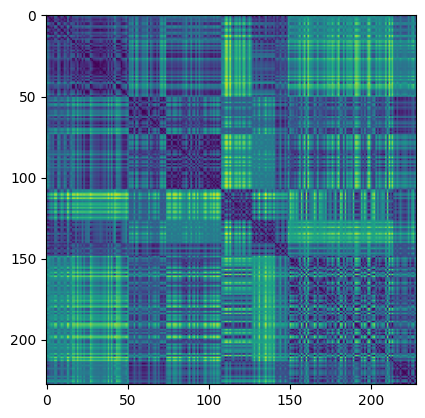

In [6]:
plt.imshow(route_distances)

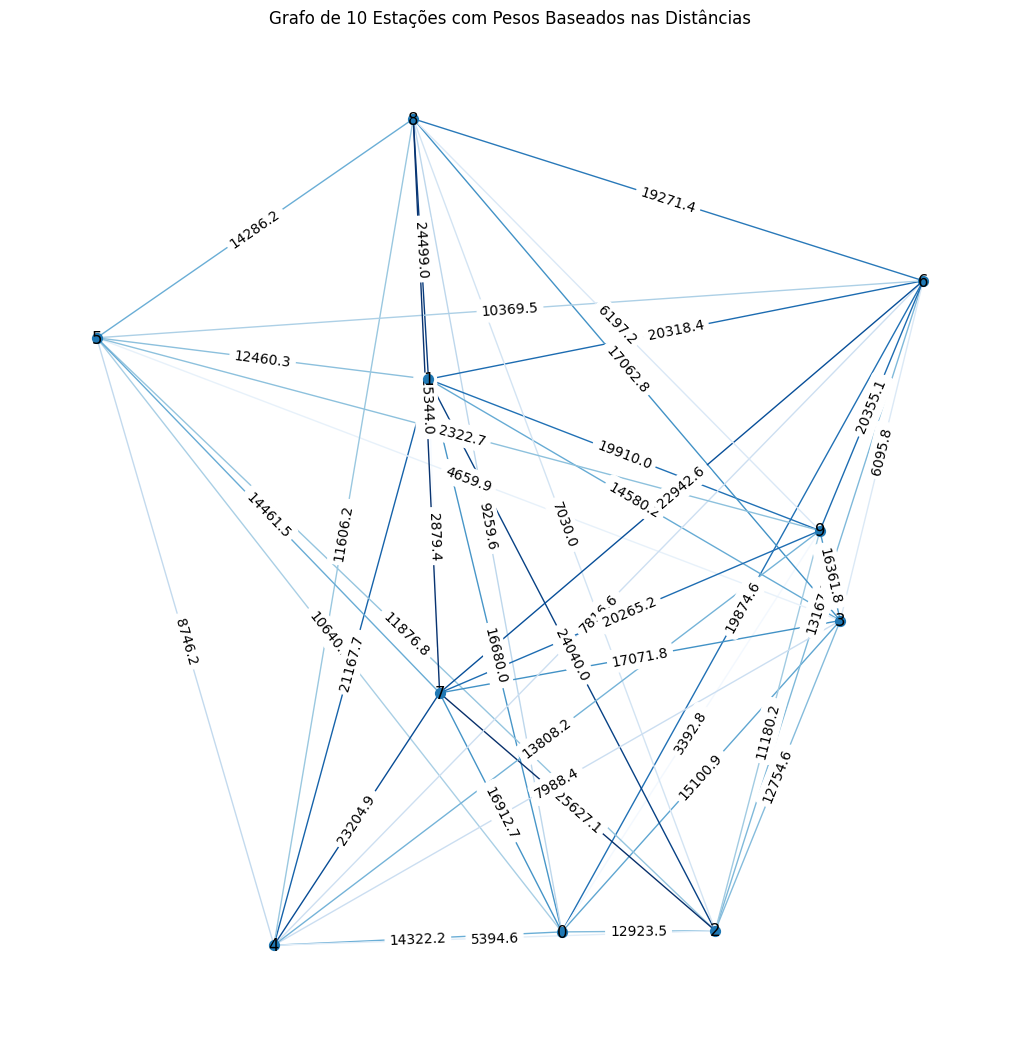

In [10]:
# Função para subamostrar as estações
def subamostrar_estacoes(route_distances, num_estacoes):
    indices = np.random.choice(route_distances.shape[0], num_estacoes, replace=False)
    sub_route_distances = route_distances[np.ix_(indices, indices)]
    return sub_route_distances, indices

num_estacoes = 10  # Altere para o número desejado de estações

# Subamostrando as estações
sub_route_distances, estacoes_indices = subamostrar_estacoes(route_distances, num_estacoes)

# Criando o grafo diretamente da matriz de adjacência (distâncias subamostradas)
G = nx.from_numpy_array(sub_route_distances)

# Plotando o grafo com as arestas ponderadas pelas distâncias
pos = nx.spring_layout(G, seed=42)  # Layout do grafo
edges = G.edges(data=True)
weights = [w['weight'] for _, _, w in edges]  # Pesos das arestas

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=50, with_labels=True, edge_color=weights, edge_cmap=plt.cm.Blues)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{w["weight"]:.1f}' for i, j, w in edges})

plt.title(f"Grafo de {num_estacoes} Estações com Pesos Baseados nas Distâncias")
plt.show()